
# Neural Computation Exercise 4-2: Training a CNN Classifier

Training a Classifier
=====================

This is it, you have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking, What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

# Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

# Load and normalize CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Using the same method we did in the last tutorial, we will take advantage of a GPU if one is available.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")


The current device is cpu


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]. Since the CIFAR10 images are RGB they are made up of 3 channels, representing the red, blue and green components of the image. The `transforms.Normalize()` function applys a normalising transformation to each channel of the data, the first tuple is a value to be subtracted from each respective channel, and the second tuple gives the value each respective channel will be divided by.  i.e.:Given `mean = (mean[1],...,mean[n])` and `std = (std[1],..,std[n])` for n channels, this transform will normalize each channel of the input torch.*Tensor: `output[channel] = (input[channel] - mean[channel]) / std[channel]`


<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:43<00:00, 3884293.04it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



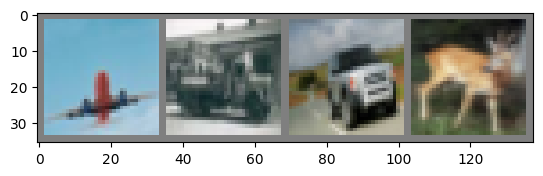

plane truck   car  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Define a Convolutional Neural Network
Here we will define the Convolutional Neural Network which we will be using to classify the images. We develop this network using some components you will be familiar with from lectures, consisting of convolutional layers, max pooling layers and fully connected layers. We use the respective pytorch sub-modules seen in the `__init__` definition below. The Pytorch documentation is a good way of seeing what each of these sub modules does. 

For the forward pass of this network we input a 3 channeled image into the neural network, and it outputs a vector of length 10. This vector contains the raw un-normalised scores for each of the 10 classes. Once trained, the class with the highest score will be the predicted class. Understanding what each sub-module in the network is doing is key, so I give a brief overview below:

- `nn.Conv2d(in_channels, out_channels, kernel_size)` - an instance of this sub-module will be a 2 d convolution layer which takes a mini-batch of images with `in_channels` and convolves these images with `out_channels` kernels of height and width `kernel_size` (and `in_channels` depth) to give an output image with `out_channels` many channels. 

- `nn.MaxPool2d(kernel_size)` - an instance of this sub-module will be a 2d maxpooling with a `kernel_size` sized kernel.

- `nn.Linear(in_channels,out_channels)` - was covered in the last tutorial and acts as a fully connected layer between a vector of length `in_features` and a vector of length `out_features`.

These are by no means exhaustive explanations, please refer to the official Pytorch documentation to find out more. The instances of these submodules, which are created in the `__init__` method, are then arranged in the `forward` method of the model to define a forward pass. Note that `F.relu()` functionals are also used in the `forward` method, however are not required to be defined in the `__init__` method, this is the case with any functionals used in the forward sequence of a neural network (one example being most activation functions).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

# Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum. The `nn.CrossEntropyLoss` only requires the raw un-normalised scores for each class, hence why we don't need a soft-max layer in our network (it is actually built into this loss function). `optim.SGD` allows us to apply minibatch gradient descent with momentum using the hyperparameters below
- learning rate = 0.001
- momentum = 0.9

Please complete the following code:


In [10]:
import torch.optim as optim
#####PLEASE COMPLETE THE FOLLOWING CODE#####
#set the criterion to the appropriate loss function and the otpimiser to the appropriate optimiser.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9)
############################################

# Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize. These lines of code are key to training networks in Pytorch and it is essential you understand how they work. They will be similar to those covered in the previous tutorial. Please complete the code below with the neccessary training steps. If you are struggling you may wish to refer to the previous tutorial.



In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels] and move them to
        #the current device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #####PLEASE COMPLETE THE FOLLOWING CODE#####
        #insert the neccessary lines of code to complete the training loop here 
        #(approx 5 lines of code)
        ############################################

        net.train()             # set the model to training mode 
        optimizer.zero_grad()     # avoid accumulating gradients
        y_pred = net(inputs)
        loss = criterion(y_pred,labels)
        loss.backward()           # calculate gradients
        optimizer.step()          # updates model's params
        
        # print statistics - epoch and loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.168
[1,  4000] loss: 1.830
[1,  6000] loss: 1.671
[1,  8000] loss: 1.587
[1, 10000] loss: 1.499
[1, 12000] loss: 1.437
[2,  2000] loss: 1.355
[2,  4000] loss: 1.339
[2,  6000] loss: 1.323
[2,  8000] loss: 1.296
[2, 10000] loss: 1.274
[2, 12000] loss: 1.284
Finished Training


Let's quickly save our trained model:



In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

# Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display a mini-batch of images from the test set to get familiar.



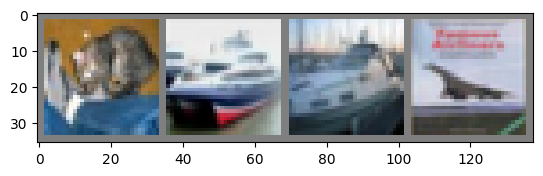

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter) #Selects a mini-batch and its labels

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are. Please assign the output of the neural network to `outputs` variable below.



In [17]:
images = images.to(device)
labels = labels.to(device)
#####PLEASE COMPLETE THE FOLLOWING CODE#####
#Assign the output of the neural network to the below variable.
outputs = net(images)
#############################################

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy.



In [18]:
_, predicted = torch.max(outputs, 1) #Returns a tuple (max,max indicies), we only need the max indicies.

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset. Below we keep track of the total numnber of predictions made by our network in the variable `total` and the number of correct predictions made by our network in the variable `correct`. This allows us to calculate the proportion of correct predictions the network makes. Please complete the code below to update these values for each mini-batch.



In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network 
        outputs = net(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        #####PLEASE COMPLETE THE FOLLOWING CODE#####
        #total should store the cumulative number of predictions made by the network 
        #correct should do the same only for correct predictions made by the network
        total += labels.size(0)              # Total number of labels
        correct += (predicted == labels).sum().item() ## Num of correct labels
        ############################################

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
It seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well. This can be some useful analysis to carry out as it can show you the limits of your neural network, and they are often areas where the network could be improved. 



In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 55.1 %
Accuracy for class car   is: 68.9 %
Accuracy for class bird  is: 39.6 %
Accuracy for class cat   is: 35.5 %
Accuracy for class deer  is: 37.0 %
Accuracy for class dog   is: 60.0 %
Accuracy for class frog  is: 74.1 %
Accuracy for class horse is: 58.3 %
Accuracy for class ship  is: 74.4 %
Accuracy for class truck is: 64.8 %


So now you have trained a convolutional neural nework to perform an image classification task, potentially on a GPU. If this is the case you may ask yourself, 'why don't I notice MASSIVE speedup compared to CPU?' The answer is simply that the network you are training is really small. 

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




